In [43]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA
import warnings
warnings.filterwarnings("ignore")

### Построение ARIMA моделей для дневных и часовых данных USD/RUB для последующего встраивания в функционал бота

In [44]:
import pandas as pd
data16= pd.read_csv("USDRUB_TOD_1day_11072022_11072023.txt", sep = ';')
data16.head()
#data3=data3.set_index('data')
#print(data16)

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<OPENINT>
0,USDRUB_TOD,D,20220711,0,61.4950,61.9400,58.800,59.2700,1169508000,0
1,USDRUB_TOD,D,20220712,0,59.0000,59.5475,57.155,58.7325,1320312000,0
2,USDRUB_TOD,D,20220713,0,58.8550,59.1900,57.870,58.4100,1167851000,0
3,USDRUB_TOD,D,20220714,0,58.2175,58.6450,57.700,58.3700,1031264000,0
4,USDRUB_TOD,D,20220715,0,58.0500,59.0000,56.500,57.3150,1180235000,0


In [45]:
data_kurs=data16[["<DATE>", "<CLOSE>"]]
from datetime import datetime
for i in range(len(data_kurs['<DATE>'])):
    data_kurs['<DATE>'][i]= datetime.strptime(str(data_kurs['<DATE>'][i]),"%Y%m%d").date()
#data_k=data_kurs.set_index('<DATE>')
data_k=data_kurs
print(data_k)

         <DATE>  <CLOSE>
0    2022-07-11  59.2700
1    2022-07-12  58.7325
2    2022-07-13  58.4100
3    2022-07-14  58.3700
4    2022-07-15  57.3150
..          ...      ...
233  2023-07-03  88.8725
234  2023-07-05  90.6325
235  2023-07-06  91.1100
236  2023-07-07  90.9725
237  2023-07-10  90.8525

[238 rows x 2 columns]


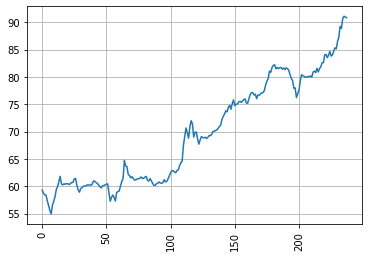

In [46]:
plt.plot(data_k["<CLOSE>"]);
plt.grid();
plt.xticks(rotation=90);

In [47]:
train=data_k["<CLOSE>"]
train

0      59.2700
1      58.7325
2      58.4100
3      58.3700
4      57.3150
        ...   
233    88.8725
234    90.6325
235    91.1100
236    90.9725
237    90.8525
Name: <CLOSE>, Length: 238, dtype: float64

In [48]:
len(train)

238

In [49]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_k["<CLOSE>"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
#p-value is more than 0.05 this means our null hypothesis will be rejected and we will take this series as non-stationary

ADF Statistic: 0.683896
p-value: 0.989511
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


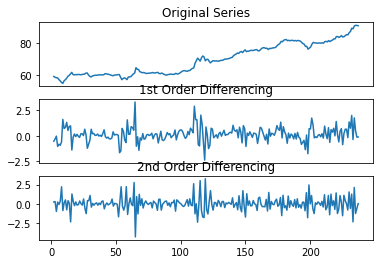

In [50]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(data_k["<CLOSE>"]); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(data_k["<CLOSE>"].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(data_k["<CLOSE>"].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()
#time series has become stationary, choose !order dif as less noisy

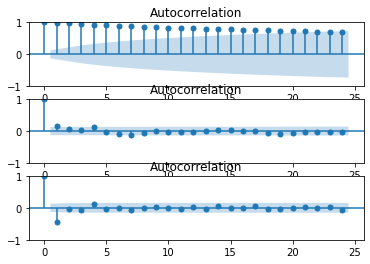

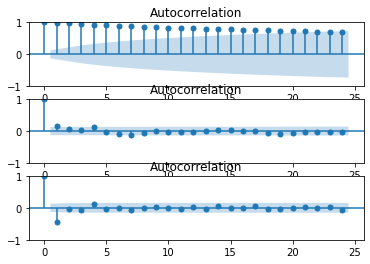

In [51]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(data_k["<CLOSE>"], ax=ax1)
plot_acf(data_k["<CLOSE>"].diff().dropna(), ax=ax2)
plot_acf(data_k["<CLOSE>"].diff().diff().dropna(), ax=ax3)
#2nd diff the immediate lag has gone on the negative side :( d=1!!!

In [52]:
data_k["<CLOSE>"].diff().dropna()

1     -0.5375
2     -0.3225
3     -0.0400
4     -1.0550
5     -0.8375
        ...  
233   -0.3775
234    1.7600
235    0.4775
236   -0.1375
237   -0.1200
Name: <CLOSE>, Length: 237, dtype: float64

In [53]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_k["<CLOSE>"].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
##p-value is less than 0.05 this means our null hypothesis will be accepted and we will take this series as stationary

ADF Statistic: -13.144519
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


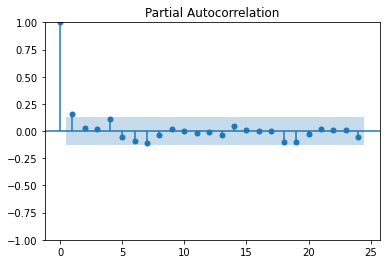

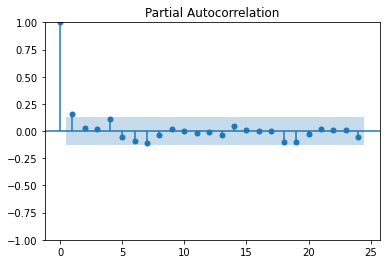

In [54]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_k["<CLOSE>"].diff().dropna())
# first lag is significantly out of the limit
#the second one is also out of the significant limit but it is not that far
#we can select the order of the p as 1!

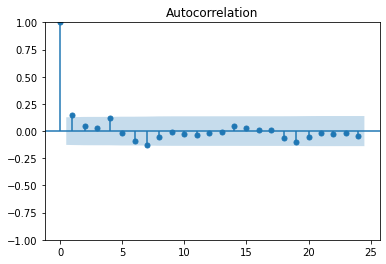

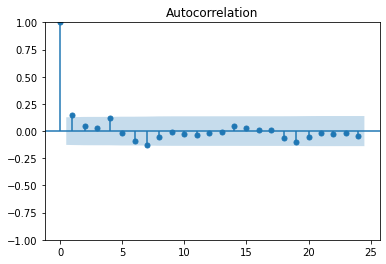

In [55]:
plot_acf(data_k["<CLOSE>"].diff().dropna())
# first lag is significantly out of the limit
#the second one is also out of the significant limit but it is not that far
#we can select the order of the q as 1!

In [56]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data_k["<CLOSE>"], order = (1,1,1))
model_fit = model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                <CLOSE>   No. Observations:                  238
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.971
Date:                Sun, 08 Sep 2024   AIC                            515.941
Time:                        20:04:28   BIC                            526.345
Sample:                             0   HQIC                           520.135
                                - 238                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6340      0.155      4.086      0.000       0.330       0.938
ma.L1         -0.4781      0.179     -2.671      0.008      -0.829      -0.127
sigma2         0.5034      0.030     16.723      0.000       0.444       0.562
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                79.51
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.30
Prob(H) (two-sided):                  0.52   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
from datetime import date
point2 = date(2023, 6, 30)
point2

datetime.date(2023, 6, 30)

In [58]:
len(data_k)//(10/8)

190.0

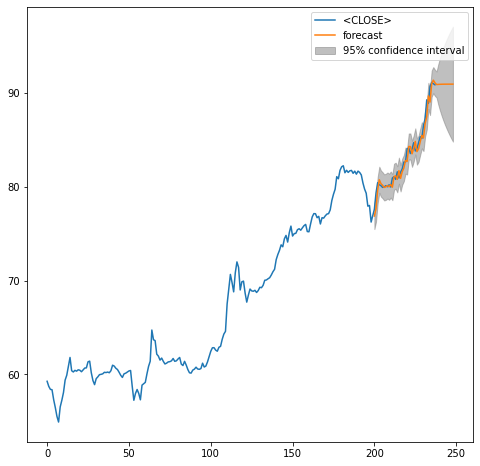

In [59]:
from statsmodels.graphics.tsaplots import plot_predict
fig, ax = plt.subplots(figsize=(8,8))
ax = data_k['<CLOSE>'].plot(ax=ax)
plot_predict(model_fit,start=200, end=248, ax=ax)
plt.savefig('prediction')
plt.show();

In [60]:
last_day=data_k['<DATE>'].iloc[-1]
last_day

datetime.date(2023, 7, 10)

In [61]:
delta=(date.today()-last_day).days
model_fit.forecast(delta).iloc[-1]

90.92215950839045

In [62]:
import pandas as pd
data15= pd.read_csv("USDRUB_TOD_1hour_01012023_13072023.txt", sep = ';')
data15.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<CLOSE>,<VOL>
0,USDRUB_TOD,60,20230109,07:00,71.9525,999
1,USDRUB_TOD,60,20230109,08:00,71.7650,3245
2,USDRUB_TOD,60,20230109,09:00,71.1700,38758
3,USDRUB_TOD,60,20230109,10:00,71.0225,137003
4,USDRUB_TOD,60,20230109,11:00,70.7500,126396


In [63]:
data_hrs=data15[["<DATE>","<CLOSE>"]]
from datetime import datetime
import datetime as dt
mytime = dt.datetime.strptime('0130','%H%M').time()
mydatetime = dt.datetime.combine(dt.date.today(), mytime)

for i in range(len(data_hrs['<DATE>'])):
    data_hrs['<DATE>'][i]= dt.datetime.combine(datetime.strptime(str(data15['<DATE>'][i]),"%Y%m%d").date(),\
                                               datetime.strptime(str(data15['<TIME>'][i]),"%H:%M").time())
    #data_hrs['<TIME>'][i]= datetime.strptime(str(data_hrs['<TIME>'][i]),"%H:%M").time()
#data_k=data_kurs.set_index('<DATE>')
data_h=data_hrs
print(data_h)

                   <DATE>  <CLOSE>
0     2023-01-09 07:00:00  71.9525
1     2023-01-09 08:00:00  71.7650
2     2023-01-09 09:00:00  71.1700
3     2023-01-09 10:00:00  71.0225
4     2023-01-09 11:00:00  70.7500
...                   ...      ...
1354  2023-07-13 11:00:00  90.0500
1355  2023-07-13 12:00:00  90.1400
1356  2023-07-13 13:00:00  90.0675
1357  2023-07-13 14:00:00  90.0625
1358  2023-07-13 15:00:00  89.9350

[1359 rows x 2 columns]


In [64]:
train=data_h["<CLOSE>"]
train

0       71.9525
1       71.7650
2       71.1700
3       71.0225
4       70.7500
         ...   
1354    90.0500
1355    90.1400
1356    90.0675
1357    90.0625
1358    89.9350
Name: <CLOSE>, Length: 1359, dtype: float64

In [65]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_h["<CLOSE>"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
#p-value is more than 0.05 this means our null hypothesis will be rejected and we will take this series as non-stationary

ADF Statistic: -0.332632
p-value: 0.920754
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


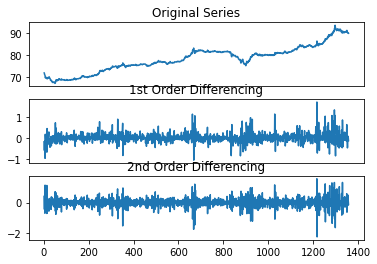

In [66]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(data_h["<CLOSE>"]); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(data_h["<CLOSE>"].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(data_h["<CLOSE>"].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()
#time series has become stationary, choose !order dif as less noisy

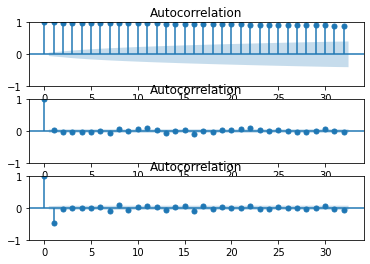

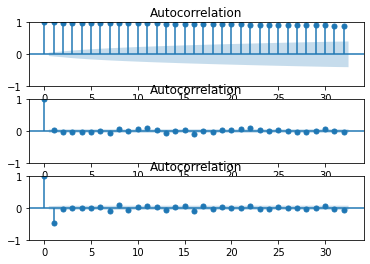

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(data_h["<CLOSE>"], ax=ax1)
plot_acf(data_h["<CLOSE>"].diff().dropna(), ax=ax2)
plot_acf(data_h["<CLOSE>"].diff().diff().dropna(), ax=ax3)
#2nd diff the immediate lag has gone on the negative side :( d=1!!!

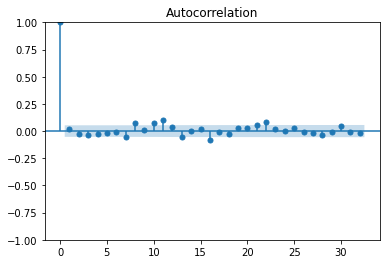

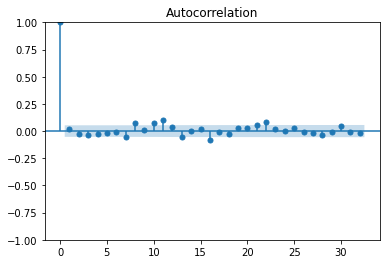

In [68]:
plot_acf(data_h["<CLOSE>"].diff().dropna())
# first lag is significantly out of the limit
#the second one is also out of the significant limit but it is not that far
#we can select the order of the q as 1!

In [69]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data_h["<CLOSE>"], order = (1,1,1))
model_fit1 = model.fit()
model_fit1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                <CLOSE>   No. Observations:                 1359
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  96.243
Date:                Sun, 08 Sep 2024   AIC                           -186.486
Time:                        20:04:42   BIC                           -170.844
Sample:                             0   HQIC                          -180.630
                               - 1359                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2978      0.593     -0.502      0.616      -1.461       0.865
ma.L1          0.3274      0.587      0.558      0.577      -0.823       1.478
sigma2         0.0508      0.001     57.129      0.000       0.049       0.053
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              3339.84
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
from datetime import date
point2 = date(2023, 6, 30)
point2

datetime.date(2023, 6, 30)

In [71]:
len(data_h)

1359

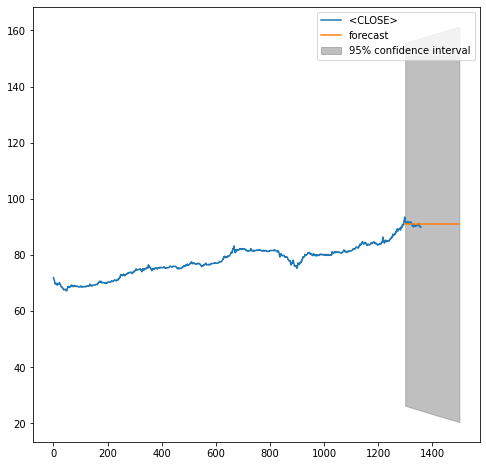

In [72]:
from statsmodels.graphics.tsaplots import plot_predict
fig, ax = plt.subplots(figsize=(8,8))
ax = data_h['<CLOSE>'].plot(ax=ax)
plot_predict(model_fit,start=1300, end=1500, ax=ax)
plt.savefig('prediction')
plt.show();

In [73]:
last_hour=data_h['<DATE>'].iloc[-1]
last_hour

datetime.datetime(2023, 7, 13, 15, 0)

In [74]:
from datetime import timedelta

now = datetime.now()
delta1=(now-last_hour)
print(delta1)
s = delta1.seconds
h, s = divmod(s, 3600)
print(h)
model_fit1.forecast(h).iloc[-1]

423 days, 5:04:50.182565
5


89.93179893714667

In [75]:
now.time()

datetime.time(20, 4, 50, 182565)

In [76]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M") 
print(current_time)
import datetime
now.time()
datetime.time(16,8)
print(now.time())

20:04
20:04:51.732118


In [77]:
import requests

In [78]:
data16= pd.read_csv("USDRUB_TOD_1day_11072022_11072023.txt", sep = ';')
data16.head()
#data3=data3.set_index('data')
#print(data16)я

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<OPENINT>
0,USDRUB_TOD,D,20220711,0,61.4950,61.9400,58.800,59.2700,1169508000,0
1,USDRUB_TOD,D,20220712,0,59.0000,59.5475,57.155,58.7325,1320312000,0
2,USDRUB_TOD,D,20220713,0,58.8550,59.1900,57.870,58.4100,1167851000,0
3,USDRUB_TOD,D,20220714,0,58.2175,58.6450,57.700,58.3700,1031264000,0
4,USDRUB_TOD,D,20220715,0,58.0500,59.0000,56.500,57.3150,1180235000,0


In [80]:
import re
import requests
from bs4 import BeautifulSoup

## Python bot

In [91]:
_telebot = ... #бот
appid = ... #погода

In [94]:
import telebot
from telebot import types

bot = telebot.TeleBot(_telebot)

@bot.message_handler(commands=['start'])
def start(message):

    markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
    btn1 = types.KeyboardButton("Привет!")
    markup.add(btn1)
    bot.send_message(message.from_user.id, "Привет! Этот бот обладает следующими функциями:\n USD close pred.- предсказание курса доллара на момент закрытия торгов,\n USD hr pred.- предсказание курса доллара на каждый час,\n USD act.- настоящий курс доллара,\n Прогноз погоды ,\n Смешная картинка кота ", reply_markup=markup)

@bot.message_handler(content_types=['text'])
def get_text_messages(message):
   

    if message.text == 'Привет!':
        markup = types.ReplyKeyboardMarkup(resize_keyboard=True) #создание новых кнопок
        btn1 = types.KeyboardButton('USD close pred.')
        btn2 = types.KeyboardButton('USD hr pred.')
        btn3 = types.KeyboardButton('USD act.')
        btn4 = types.KeyboardButton('Прогноз погоды')
        btn5 = types.KeyboardButton('Смешная картинка кота')
        markup.add(btn1, btn2, btn3, btn4, btn5)
        bot.send_message(message.from_user.id, 'Что вам нужно?', reply_markup=markup) #ответ бота


    elif message.text == 'USD close pred.':
        delta=(date.today()-last_day).days
        kurs=model_fit.forecast(delta).iloc[-1]
        bot.send_message(message.from_user.id,round(kurs,2))
        
    elif message.text == 'USD hr pred.':
        now = datetime.datetime.now()
        delta1=(now-last_hour)
        s = delta1.seconds
        h, s = divmod(s, 3600)
        kurs=model_fit1.forecast(h).iloc[-1]
        bot.send_message(message.from_user.id,round(kurs,2))
        
    elif message.text == 'USD act.':
        response = requests.get('https://api.exchangerate-api.com/v4/latest/USD')
        data = response.json()
        rate = data['rates']['RUB']
        # Отправляем сообщение с курсом доллара
        bot.reply_to(message, f'Курс доллара: 1 USD = {rate} RUB')

    elif message.text == 'Прогноз погоды':
        markup1 = types.ReplyKeyboardMarkup(resize_keyboard=True)
        btn1 = types.KeyboardButton("Самара")
        btn2 = types.KeyboardButton("Москва")
        markup1.add(btn1, btn2)
        bot.send_message(message.from_user.id, "Выберите пожалуйста город :)", reply_markup=markup1)
    
    elif message.text == "Самара" or message.text == "Москва":
        if message.text == "Самара":
            s_city = "Samara,RU"
        if message.text == "Москва":
            s_city = "Moscow,RU"
        city_id = 0
        try:
            res = requests.get("http://api.openweathermap.org/data/2.5/find",
                 params={'q': s_city, 'type': 'like', 'units': 'metric', 'APPID': appid})
            data = res.json()
            print(data)
            cities = ["{} ({})".format(d['name'], d['sys']['country']) for d in data['list']]
            print("city:", cities)
            city_id = data['list'][0]['id']
            print('city_id=', city_id)
        except Exception as e:
            print("Exception (find):", e)
            pass
        try:
            res = requests.get("http://api.openweathermap.org/data/2.5/weather",
                 params={'id': city_id, 'units': 'metric', 'lang': 'ru', 'APPID': appid})
            data = res.json()
            print("conditions:", data['weather'][0]['description'])
            print("temp:", data['main']['temp'])
            print("temp_min:", data['main']['temp_min'])
            print("temp_max:", data['main']['temp_max'])
            answer="Погодные условия: "+data['weather'][0]['description']+"\nТемпература: "+str( data['main']['temp'])\
            +"\n Минимальная температура: "+ str(data['main']['temp_min'])+"\n Максимальная температура: "+str(data['main']['temp_max']) 
        except Exception as e:
            print("Exception (weather):", e)
            pass
        markup = types.ReplyKeyboardMarkup(resize_keyboard=True) #создание новых кнопок
        btn1 = types.KeyboardButton('USD close pred.')
        btn2 = types.KeyboardButton('USD hr pred.')
        btn3 = types.KeyboardButton('USD act.')
        btn4 = types.KeyboardButton('Прогноз погоды')
        btn5 = types.KeyboardButton('Смешная картинка кота')
        markup.add(btn1, btn2, btn3, btn4, btn5)
        bot.send_message(message.from_user.id, answer, reply_markup=markup)

    elif message.text == 'Смешная картинка кота':
        site = 'https://uprostim.com/150-kartinok-so-smeshnymi-kotami-prikolnye-foto-s-nadpisyami/'
        response = requests.get(site)
        soup = BeautifulSoup(response.text, 'html.parser')
        img_tags = soup.find_all('img')

        urls = [img['src'] for img in img_tags]
        while True:
            nanana=np.random.randint(0,206)
            url=urls[nanana]
            filename = re.search(r'/([\w_-]+[.](jpg|gif|png))$', url)
            if not filename:
                continue
            if 'http' not in url:
                    # sometimes an image source can be relative 
                    # if it is provide the base url which also happens 
                    # to be the site variable atm. 
                url = '{}{}'.format(site, url)
            response = requests.get(url)
            image=response.url
            break
        bot.send_photo(message.from_user.id, image)

bot.polling(none_stop=True, interval=0) #обязательная для работы бота часть